In [1]:
import os
import numpy as np
import tensorflow as tf
import scipy.signal as sps
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pickle


data_dir = os.path.join(os.getcwd(), "data", "mini_speech_commands")

def downsample_waveform(waveform, num_bins):
    waveform = np.array(waveform)
    original_length = len(waveform)
    points_per_bin = original_length // num_bins
    downsampled_waveform = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * points_per_bin
        end_index = start_index + points_per_bin
        downsampled_waveform[i] = waveform[start_index:end_index].mean()
    return downsampled_waveform.tolist()

def add_white_noise(audio):
    #generate noise and the scalar multiplier
    noise = tf.random.uniform(shape=tf.shape(audio), minval=-1, maxval=1)
    noise_scalar = tf.random.uniform(shape=[1], minval=0, maxval=0.2)
    # add them to the original audio
    audio_with_noise = audio + (noise * noise_scalar)
    # final clip the values to ensure they are still between -1 and 1
    audio_with_noise = tf.clip_by_value(audio_with_noise, clip_value_min=-1, clip_value_max=1)
    return audio_with_noise

def extract_features(audio_file_path, window_size=1024, overlap=0, num_bins=16):
    sample_rate, audio_data = wavfile.read(audio_file_path)
    resampled_audio = sps.resample(audio_data, sample_rate)
    # Add white noise to the audio
    augmented_audio = add_white_noise(resampled_audio)
    step_size = window_size - overlap
    num_windows = (len(augmented_audio) - window_size) // step_size + 1
    fft_results = []
    for i in range(num_windows):
        start_index = i * step_size
        end_index = start_index + window_size
        windowed_signal = augmented_audio[start_index:end_index]
        
        fft_result = np.fft.fft(windowed_signal)
        fft_result = fft_result[0:int(fft_result.shape[0] / 2)]
        fft_magnitude = np.abs(fft_result)
        fft_magnitude[0] = 0
        fft_magnitude = downsample_waveform(fft_magnitude, num_bins)
        fft_results.extend(fft_magnitude)
    return np.array(fft_results)


In [2]:
def load_data(data_dir):
    waveforms = []
    labels = []
    for dirname in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, dirname)
        if not dirname in labels:
            labels.append(dirname)
        wav_files = [os.path.join(label_dir, fname) for fname in os.listdir(label_dir)]
        feature_arr = []
        for wav_file in wav_files:
            xfeatures = extract_features(wav_file)
            feature_arr.append(xfeatures)
        waveforms.append(np.array(feature_arr))
        del feature_arr
    return np.array(waveforms), np.array(labels)


audio_data, labels = load_data(data_dir)

print(np.shape(audio_data))
print(np.shape(labels))

(8, 1000, 240)
(8,)


In [8]:
x, y = audio_data, labels
input_shape= np.shape(x)[1:]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Dense(12, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer="adam",
    loss="binary_cross_entropy",
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1000, 12)       │         2,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000, 8)        │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1000, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 3,005 (11.74 KB)

 Non-trainable params: 0 (0.00 B)

# Sklearn Models

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

x, y = audio_data, labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6, 1000, 240)
(2, 1000, 240)
(6,)
(2,)


In [4]:
x = np.reshape(x, (8, 1000*240))
y = np.ravel(y)
model = SGDClassifier(random_state=42)
x_train = np.reshape(x_train, (6, 1000*240))
y_train = np.ravel(y_train)
model.fit(x, y)
x_test = np.reshape(x_test, (2, 1000*240))
y_test = np.ravel(y_test)
score = model.score(x_train, y_train)
print(score)

1.0


In [6]:
outfile = os.path.join(os.getcwd(), "models", "model.pickle")
with open(outfile, "wb") as fh:
    pickle.dump(model, fh)

# The only reason for using sklearn model

In [6]:
import m2cgen

code = m2cgen.export_to_python(model)
with open("svm.py", "w") as fh:
    fh.write(code)

: 

# RGB Dataset

Sample Rate: 44100


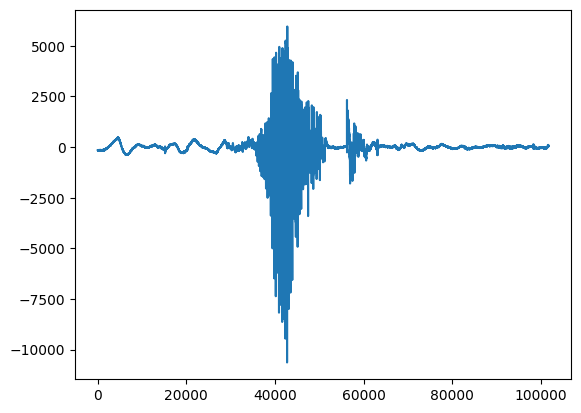

In [5]:
audio_path = os.path.join(os.getcwd(), "rgb_wavs", "rgb", "red", "red2.wav")
sample_rate, audio_data = wavfile.read(audio_path)
print("Sample Rate: {}".format(sample_rate))
plt.plot(audio_data)

# Nonsense

In [ ]:
# trim audio files to 1 second
rgb_dir = os.path.join(os.getcwd(), "rgb_wavs", "rgb")
label_names = ["red", "green", "blue"]
audio_paths = [os.path.join(rgb_dir, c) for c in label_names]

audio_path = os.path.join(os.getcwd(), "rgb_wavs", "rgb", "red", "red2.wav")
sr, a = wavfile.read(audio_path)
n = np.shape(a)[0]
print(n)
s = n % sr
ns = n // s
x = ns * (s // 2)
new_audio = a[ns:n-sr]
print(np.shape(new_audio))
plt.figure(1)
plt.plot(new_audio)
plt.figure(2)
plt.plot(a)